In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from dataset import IHarmDataset, get_preprocessing, get_augmentation
from unet import UNet

import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import albumentations as albu
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt
import numpy as np
import cv2

def show(im):
    im = np.transpose(im, (2, 1, 0))
    plt.figure()
    plt.imshow((255 * im).astype(np.uint8))

In [3]:
datapath = "../image_harmonization/HAdobe5k/"
preprocessing = get_preprocessing()
# augmentation = get_augmentation()
dataset = IHarmDataset(datapath, preprocessing, None)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=1)

In [ ]:
device = "cpu"
cp = "checkpoints/cp_best_l1_ssim.pth"

net = UNet(7, 3)
net.load_state_dict(torch.load(cp))
net.to(device)

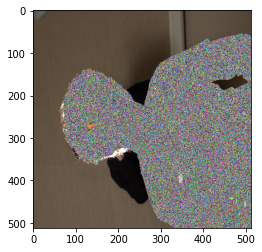

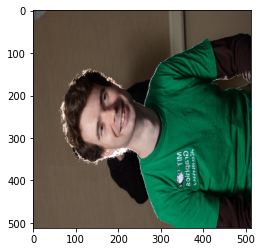

In [8]:
for _ in range(1):
    batch = next(iter(dataloader))
    c, m, h = batch["comp"], batch["mask"], batch["hist"]

    with torch.no_grad():
        pred = net(c.to(device), m.to(device), h.to(device))

    pred = pred.detach().cpu().numpy()
    y = batch["real"].detach().cpu().numpy()

    show(pred[0])
    show(y[0])